In [28]:
import numpy as np
import matplotlib.pyplot as plt
import math
import vector
import awkward as ak

In [29]:
"""Read in SM and EFT data from .npy files
Set run variable to the folder containing the set of selections applied to the data
which is usually the date ran in the format 'ddmmyy"""
sm_run = '090324_2'
# eft_run = '090324_2'
# eft_run = '130324_chbtil_0.1'
eft_run = '050424_chbtil_0.5'

'Each element in the list is a numpy array of the data for one sample run'
sm_tau_data = []
sm_muon_data = []
sm_weights = []

# Change commented out code if testing with different data

for i in range(1,6):
    sm_tau_data.append(np.load(f'sm_data/{sm_run}/sm_taus_run_{i}.npy'))
    sm_muon_data.append(np.load(f'sm_data/{sm_run}/sm_muons_run_{i}.npy'))
    sm_weights.append(np.load(f'sm_data/{sm_run}/sm_weights_run_{i}.npy'))

eft_tau_data = []
eft_muon_data = []
eft_weights= []

eft_tau_data.append(np.load(f'eft_data/{eft_run}/eft_taus_run_1.npy'))
eft_muon_data.append(np.load(f'eft_data/{eft_run}/eft_muons_run_1.npy'))
eft_weights.append(np.load(f'eft_data/{eft_run}/eft_weights_run_1.npy'))

# for i in range(1,6):
#     eft_tau_data.append(np.load(f'eft_data/{eft_run}/eft_taus_run_{i}.npy'))
#     eft_muon_data.append(np.load(f'eft_data/{eft_run}/eft_muons_run_{i}.npy'))
#     eft_weights.append(np.load(f'eft_data/{eft_run}/eft_weights_run_{i}.npy'))

In [30]:
"""This is a very messy method of reading in the data
and reconstructing the vectors.
It is definitely worth revisiting
though it saves having to run the selections every time

The .npy files seem to save data for each tau as:
(pt, phi, eta, mass, charge, tautag)"""

sm_taus = []
for j in sm_tau_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    tautag = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]]) # NOTE these are flipped with eta!
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        charge.append([i[0][4], i[1][4]])
        tautag.append([i[0][5], i[1][5]])
    taus = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass,'charge':charge,'tautag':tautag})
    sm_taus.append(taus)

eft_taus = []
for j in eft_tau_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    tautag = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]])
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        charge.append([i[0][4], i[1][4]])
        tautag.append([i[0][5], i[1][5]])
    taus = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass,'charge':charge,'tautag':tautag})
    eft_taus.append(taus)

"""The .npy files seem to save data for each muon as:
(pt, phi, eta, mass)"""

sm_muons = []
for j in sm_muon_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]])
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        try:
            charge.append([i[0][4], i[1][4]])
        except:
            pass
    if len(charge) > 0:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass, 'charge':charge})
    else:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass})
    sm_muons.append(muons)

eft_muons = []
for j in eft_muon_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]])
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        try:
            charge.append([i[0][4], i[1][4]])
        except:
            pass
    if len(charge) > 0:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass, 'charge':charge})
    else:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass})
    eft_muons.append(muons)

In [31]:
"""Plot the ditau invariant mass distribution
using whichever event mask is passed to it given the current cuts"""
def ditau_inv_mass(ditau, weights, model):
    #calculate the ditau invariant mass and plot it using matplotlib
    ditau_mass = (ditau[:,0]+ditau[:,1]).mass
    plt.hist(ditau_mass, bins=25, histtype='step', color='k', weights=weights)
    plt.xlabel('Mass [GeV]')
    plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$')
    plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
    plt.title(r'{} di-$\tau$ invariant mass distribution'.format(model.upper()))
    plt.savefig("ditau_mass_{}.png".format(model))

In [32]:
def histogram(data, weights, bins, label, colour, range, plot = True):
    """Unfortunately, plt.hist does not support error bars, so we have to use plt.errorbar
    using manual inputs from np.histogram"""
    nphisto = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
    err = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
    if plot:
        plt.hist(data, bins=bins, histtype='step', range = range, color=colour, weights=weights, label=label)
        plt.errorbar(nphisto[1][:-1]+((range[1]-range[0])/(2*bins)), nphisto[0], yerr=np.sqrt(err[0]), fmt='.', color=colour)
        plt.xlim(range)
        plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
        plt.legend()
    return nphisto, np.sqrt(err[0])

In [33]:
def SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, bins, label, colour, range):
    smeft_histo = sm_histo[0] + eft_histo[0]
    smeft_err = np.sqrt(sm_err**2 + eft_err**2)
    plt.errorbar(sm_histo[1][:-1]+((range[1]-range[0])/(2*bins)), smeft_histo, yerr=smeft_err, fmt='.', color=colour)
    smeft_histo_full = np.append(smeft_histo, smeft_histo[-1])
    plt.step(sm_histo[1], smeft_histo_full, where='post', color=colour, label=label)
    plt.xlim(range)
    plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
    plt.legend()
    return smeft_histo, smeft_err

In [34]:
# def likelihood(smeft, sm, sm_data):
#     """Calculate the likelihood ratio for each event"""
#     sm_total = np.sum(sm)
#     sm_scale = len(sm_data) * 1.7*10**(-5)
#     sm_events = [round((i/sm_total) * sm_scale) for i in sm]
#     smeft_total = np.sum(smeft)
#     smeft_scale = len(sm_data) * 1.7*10**(-5)
#     smeft_events = [(i/smeft_total) * smeft_scale for i in smeft]
#     likelihood_ratio = 1
#     for i, j in zip(sm_events, smeft_events):
#         expo = math.exp(-j)
#         power = j**i
#         factorial = math.factorial(i)
#         likelihood_ratio *= math.exp(-j) * (j**i) / math.factorial(i)
#     return likelihood_ratio

"""Try a new approach
number of expected events = cross section * luminosity * efficiency
so for events we just multiply bin by luminosity....?"""

def likelihood(smeft, sm):
    luminosity = 1.7 * 10**(6) # pb^-1
    #luminosity = (1.7495873e-05)**(-1)
    sm_events = sm * luminosity
    smeft_events = smeft * luminosity
    print('Background event yields: ', sm_events)
    print('total yield: ', sum(sm_events))
    print('Background + signal event yields: ', smeft_events)
    print('total yield: ', sum(smeft_events))
    likelihood = 1
    for i, j in zip(sm_events, smeft_events):
        # expo = math.exp(-j)
        # power = j**i
        # factorial = math.factorial(round(i))
        # print(expo, power, factorial)
        likelihood *= math.exp(-j) * (j**i) / math.gamma(i+1) # approximate as integer? NOTE: gamma function defined with the +1
    return likelihood

In [55]:
"""Bohm-Zech method of calculating the likelihood ratio"""

def likelihood_bz(sm, sm_err, smeft, smeft_err, eft_err):
    luminosity = 1.7 * 10**(6) # pb^-1
    sm_events = sm * luminosity
    smeft_events = smeft * luminosity
    sm_s = [i/j for i,j in zip(sm, sm_err)]
    smeft_s = [i/j for i,j in zip(smeft, sm_err+eft_err)] # adding (not in quadrature)
    sm_prime = [i/j for i,j in zip(sm_events, sm_s)]
    smeft_prime = [i/j for i,j in zip(smeft_events, smeft_s)]
    H1 = log_L(sm_prime, sm_prime)
    H0 = log_L(smeft_prime, sm_prime)
    q = 2*(H1-H0)
    return q

def log_L(mu, n):
    log_L = 0
    for i, j in zip(mu, n):
        log_L += j*math.log(i) - i
    return log_L


In [36]:
from iminuit import Minuit
from iminuit.cost import BinnedNLL

"need to define a cdf"
def cdf(x, mu, sigma):
    """What model is this?????"""
    pass

def p_val_minuit(smeft, sm, luminosity = 1.7 * 10**(6)):
    xe = sm[1]
    n_smeft = smeft * luminosity
    n_sm = sm[0] * luminosity
    return(sm[1])
    # c = BinnedNLL(smeft, sm)
    # m = Minuit(c, pedantic=False)
    # m.migrad()
    # return m.values, m.errors


In [37]:
def np_q(H0, H1):
    return -2*np.log(H0/H1)

In [38]:
def delta_phi_rapidity(leptons):
    delta_phi_lep_y = []
    for i in leptons:
        if i[0].rapidity > i[1].rapidity:
            delta_phi_lep_y.append(i[0].deltaphi(i[1]))
        else:
            delta_phi_lep_y.append(i[1].deltaphi(i[0]))
    return delta_phi_lep_y

In [39]:
from scipy.stats import chi2

def find_p_val(likelihood, ndof):
    return 1 - chi2.cdf(likelihood, ndof)

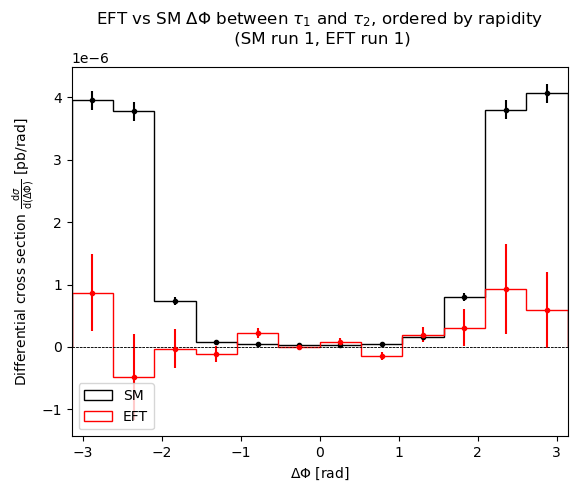

In [40]:
"""Plot the delta phi between the two taus ordered by rapidity
set sm and eft to the index of the sample run"""

sm = 1
eft = 1
bins = 12
plot_range = (-math.pi, math.pi)

delta_phi_tau_y_sm = delta_phi_rapidity(sm_taus[sm-1])
delta_phi_tau_y_eft = delta_phi_rapidity(eft_taus[eft-1])

histogram(delta_phi_tau_y_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_phi_tau_y_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)
plt.xlabel(r'$\Delta \Phi$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \Phi)}$ [pb/rad]')
plt.title(r'EFT vs SM $\Delta \Phi$ between $\tau_1$ and $\tau_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_phi_tau_y")

q:  7.821356773641796
a =  0.7292114718397518


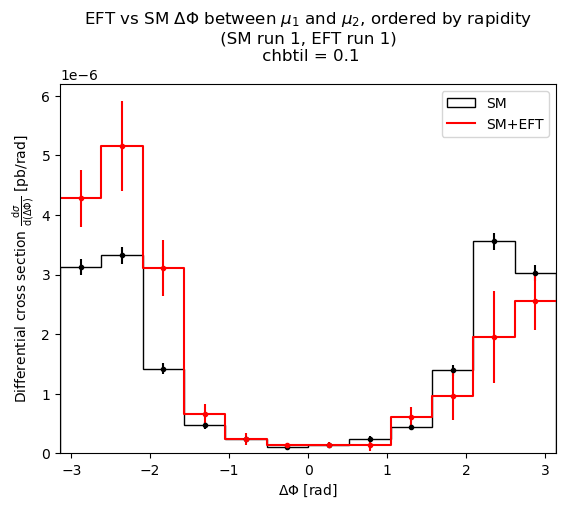

In [58]:
"""Plot the delta phi between the two muons ordered by rapidity
set sm and eft to the index of the sample run"""
sm = 1
eft = 1
bins = 12
plot_range = (-math.pi, math.pi)
luminosity = 1.7 * 10**(6) # pb^-1

delta_phi_mu_y_sm = delta_phi_rapidity(sm_muons[sm-1])
delta_phi_mu_y_eft = delta_phi_rapidity(eft_muons[eft-1])
# print(len(delta_phi_mu_y_sm), len(delta_phi_mu_y_eft))

sm_histo, sm_err = histogram(delta_phi_mu_y_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err = histogram(delta_phi_mu_y_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range, False)
smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, bins, 'SM+EFT', 'r', plot_range)
# print(p_val_minuit(smeft_histo, sm_histo, luminosity))
"""How to define H1, H0?"""
# H1 = likelihood(smeft_histo, sm_histo[0])
# H0 = likelihood(sm_histo[0], sm_histo[0])
"""or???"""
# H1 = likelihood(smeft_histo, smeft_histo)
# H0 = likelihood(smeft_histo, sm_histo[0])
# H0 = likelihood(smeft_histo, sm_histo[0])
# H1 = likelihood(sm_histo[0], sm_histo[0])
# print('H1 Likelihood: ', H1,'\nH0 Likelihood: ', H0)
# print('q: ', np_q(H0,H1))
# print('a = ', find_p_val(np_q(H0,H1), bins-1))
# colours = ['r', 'g', 'b', 'c', 'm']
# for i in range(1,6):
#     delta_phi_mu_y_eft = delta_phi_rapidity(eft_muons[i-1])
#     eft_histo, eft_err = histogram(delta_phi_mu_y_eft, eft_weights[i-1], bins, f'EFT run {i}', 'r',  plot_range, False)
#     smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, bins, f'SM+EFT {i}', colours[i-1], plot_range)


"""Bohm-Zech method"""
q = likelihood_bz(sm_histo[0], sm_err, smeft_histo, smeft_err, eft_err) # slightly confusing but these are all the relevant arrays
print('q: ', q)
print('a = ', find_p_val(q, bins-1))

plt.xlabel(r'$\Delta \Phi$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \Phi)}$ [pb/rad]')
plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 0.1')
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + '\n chbtil = 0.1')
plt.savefig("delta_phi_mu_y")

In [97]:
'''Check cross section magnitudes by integrating the histograms
and comparing to the madgraph cross section * efficiency of selection'''

print('Integrated SM cross section:', np.sum(sm_histo[0]))
print('Integrated EFT cross section:', np.sum(eft_histo[0]))

sm_cross_sections = [0.00022695, 0.00022707, 0.00022714, 0.00022703, 0.00022693]
eft_cross_sections = [-8.8921e-07, -1.291e-07, 9.4202e-07, 0.00016228, 2.2907e-06]

import uproot

sm_tree = uproot.open(f'../../Final_Samples/delphes_ee_zh_mumutautau_sm_PDFs_50000events_230224_Run{sm}.root:Delphes')
sm_events = sm_tree.arrays(['Event.Weight'])
eft_tree = uproot.open(f'../../Final_Samples/delphes_ee_mumutautau_smeft_PDFs_50000events_040324_Run{eft}.root:Delphes')
eft_events = eft_tree.arrays(['Event.Weight'])

sm_efficiency = len(sm_muons[sm-1])/len(sm_events)
eft_efficiency = len(eft_muons[eft-1])/len(eft_events)

print('Madgraph SM cross section:', sm_cross_sections[sm-1] * sm_efficiency)
print('Madgraph EFT cross section:', eft_cross_sections[eft-1] * eft_efficiency)
print('Madgraph SM expected number of events:', sm_cross_sections[sm-1] * sm_efficiency * 1.7 * 10**(6))

Integrated SM cross section: 1.7495873e-05
Integrated EFT cross section: -6.7222715e-08
Madgraph SM cross section: 1.749574184694866e-05
Madgraph EFT cross section: -6.025184720297768e-08
Madgraph SM expected number of events: 29.742761139812718


In [10]:
"""Try angular distance between jets
delta R = sqrt(delta phi^2 + delta eta^2)"""
def delta_R(leptons):
    delta_R = []
    for i in leptons:
        """I don't actually think ordering makes a difference here since it isn't signed?
        But may as well"""
        if i[0].rapidity > i[1].rapidity:
            delta_R.append(i[0].deltaR(i[1]))
        else:
            delta_R.append((i[1].deltaR(i[0])))
    return delta_R

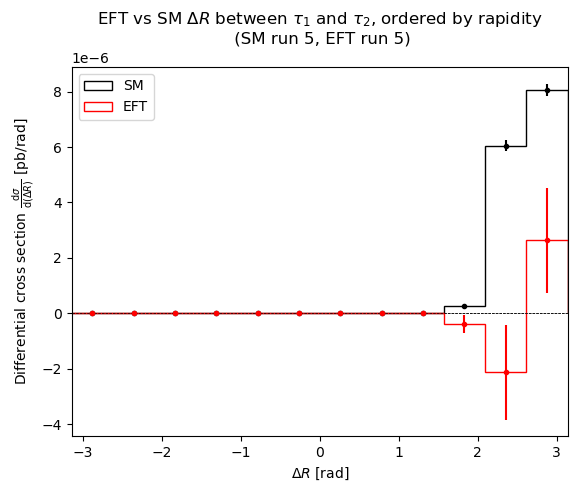

In [11]:
""""Delta R between the two taus ordered by rapidity"""
sm = 5
eft = 5
bins = 12
plot_range = (-math.pi, math.pi)

delta_R_sm = delta_R(sm_taus[sm-1])
delta_R_eft = delta_R(eft_taus[eft-1])

histogram(delta_R_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_R_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$\Delta R$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta R)}$ [pb/rad]')

plt.title(r'EFT vs SM $\Delta R$ between $\tau_1$ and $\tau_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_R_tau_y")

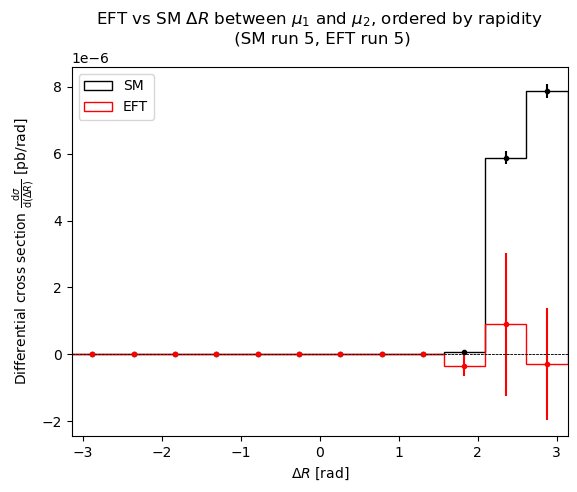

In [12]:
""""Delta R between the two muons ordered by rapidity"""
sm = 5
eft = 5
bins = 12
plot_range = (-math.pi, math.pi)

delta_R_sm = delta_R(sm_muons[sm-1])
delta_R_eft = delta_R(eft_muons[eft-1])

histogram(delta_R_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_R_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$\Delta R$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta R)}$ [pb/rad]')

plt.title(r'EFT vs SM $\Delta R$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_R_mu_y")

In [13]:
"""Find pt of lepton with highest pt"""
def highest_pt(leptons):
    highest_pt = []
    for i in leptons:
        if i[0].pt > i[1].pt:
            highest_pt.append(i[0].pt)
        else:
            highest_pt.append(i[1].pt)
    return highest_pt

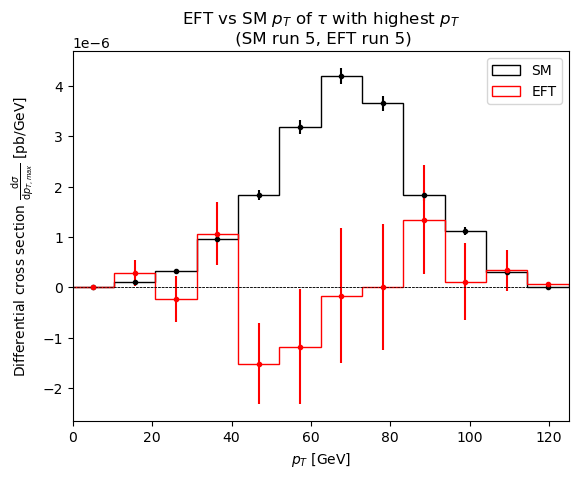

In [14]:
"""Highest pt tau distribution"""
sm = 5
eft = 5
bins = 12
plot_range = (0, 125)

highest_pt_tau_sm = highest_pt(sm_taus[sm-1])
highest_pt_tau_eft = highest_pt(eft_taus[eft-1])

histogram(highest_pt_tau_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(highest_pt_tau_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$p_T$ [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}p_{T,max}}$ [pb/GeV]')
plt.title(r'EFT vs SM $p_T$ of $\tau$ with highest $p_T$' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("highest_pt_tau")

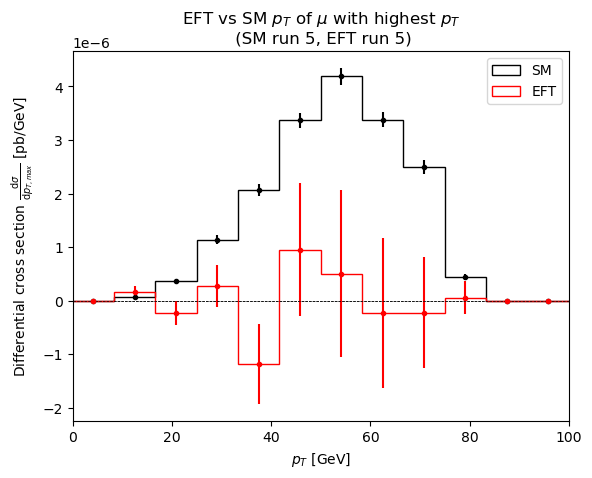

In [15]:
"""Highest pt muon distribution"""
sm = 5
eft = 5
bins = 12
plot_range = (0, 100)

highest_pt_mu_sm = highest_pt(sm_muons[sm-1])
highest_pt_mu_eft = highest_pt(eft_muons[eft-1])

histogram(highest_pt_mu_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(highest_pt_mu_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$p_T$ [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}p_{T,max}}$ [pb/GeV]')
plt.title(r'EFT vs SM $p_T$ of $\mu$ with highest $p_T$' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("highest_pt_mu")

In [16]:
"""sci-kit hep vector has a delta angle function
Doesn't seem as physically helpful as delta phi and is unsigned
but may as well try it"""

def delta_angle_rapidity(leptons):
    delta_angle_lep_y = []
    for i in leptons:
        """Almost definitely doesn't depend on rapidity order"""
        if i[0].rapidity > i[1].rapidity:
            delta_angle_lep_y.append(i[0].deltaangle(i[1]))
        else:
            delta_angle_lep_y.append(i[1].deltaangle(i[0]))
    return delta_angle_lep_y

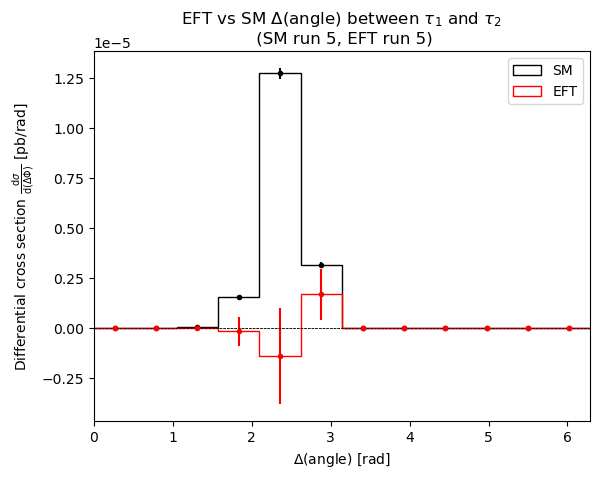

In [17]:
"""Plot the delta angle between the two taus ordered by rapidity
set sm and eft to the index of the sample run"""

sm = 5
eft = 5
bins = 12
plot_range = (0, 2*math.pi)

delta_angle_tau_sm = delta_angle_rapidity(sm_taus[sm-1])
delta_angle_tau_eft = delta_angle_rapidity(eft_taus[eft-1])

histogram(delta_angle_tau_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_angle_tau_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)
plt.xlabel(r'$\Delta$(angle) [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \Phi)}$ [pb/rad]')
plt.title(r'EFT vs SM $\Delta$(angle) between $\tau_1$ and $\tau_2$' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_angle_tau")

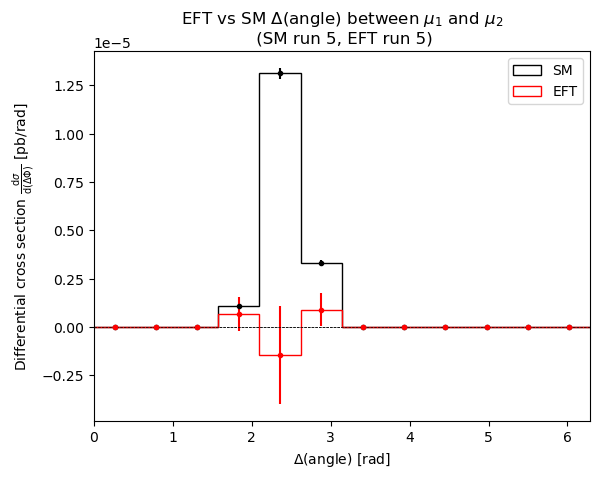

In [18]:
"""Plot the delta angle between the two taus ordered by rapidity
set sm and eft to the index of the sample run"""

sm = 5
eft = 5
bins = 12
plot_range = (0, 2*math.pi)

delta_angle_mu_sm = delta_angle_rapidity(sm_muons[sm-1])
delta_angle_mu_eft = delta_angle_rapidity(eft_muons[eft-1])

histogram(delta_angle_mu_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_angle_mu_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)
plt.xlabel(r'$\Delta$(angle) [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \Phi)}$ [pb/rad]')
plt.title(r'EFT vs SM $\Delta$(angle) between $\mu_1$ and $\mu_2$' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_angle_mu")

In [19]:
""""Scikit-hep vector has a delta eta function which IS signed
let's order by rapidity"""
def delta_eta_rapidity(leptons):
    delta_eta = []
    for i in leptons:
        if i[0].rapidity > i[1].rapidity:
            delta_eta.append(i[0].deltaeta(i[1]))
        else:
            delta_eta.append(i[1].deltaeta(i[0]))
    return delta_eta

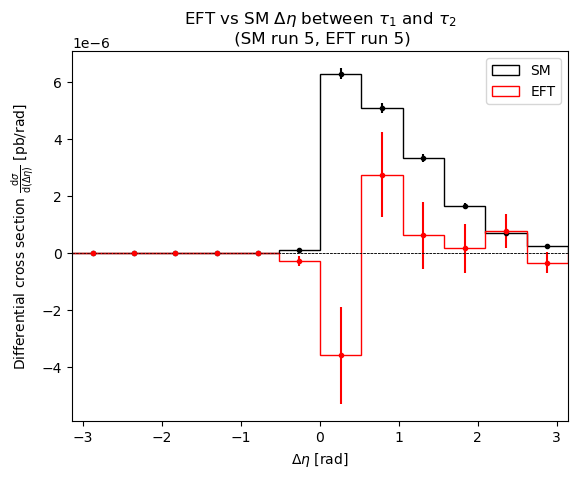

In [20]:
"""Plot the delta eta between the two taus ordered by rapidity
set sm and eft to the index of the sample run"""

sm = 5
eft = 5
bins = 12
plot_range = (-math.pi, math.pi)

delta_eta_tau_y_sm = delta_eta_rapidity(sm_taus[sm-1])
delta_eta_tau_y_eft = delta_eta_rapidity(eft_taus[eft-1])

histogram(delta_eta_tau_y_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_eta_tau_y_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)
plt.xlabel(r'$\Delta \eta$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \eta)}$ [pb/rad]')
plt.title(r'EFT vs SM $\Delta \eta$ between $\tau_1$ and $\tau_2$' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_eta_tau")

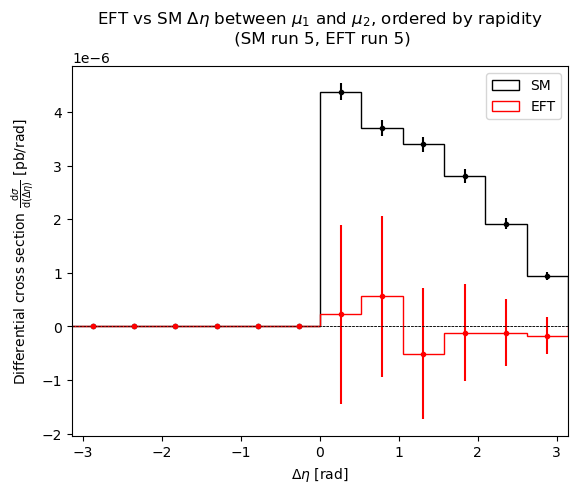

In [21]:
"""Plot the delta eta between the two muons ordered by rapidity
set sm and eft to the index of the sample run"""

sm = 5
eft = 5
bins = 12
plot_range = (-math.pi, math.pi)

delta_eta_mu_y_sm = delta_eta_rapidity(sm_muons[sm-1])
delta_eta_mu_y_eft = delta_eta_rapidity(eft_muons[eft-1])

histogram(delta_eta_mu_y_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_eta_mu_y_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)
plt.xlabel(r'$\Delta \eta$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \eta)}$ [pb/rad]')
plt.title(r'EFT vs SM $\Delta \eta$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_angle_mu")

In [43]:
"""Try pt+ - pt-"""
def delta_pt_charge(leptons):
    delta_pt_charge = []
    for i in leptons:
        if i[0].charge == 1:
            delta_pt_charge.append(i[0].pt - i[1].pt)
        else:
            delta_pt_charge.append(i[1].pt - i[0].pt)
    return delta_pt_charge

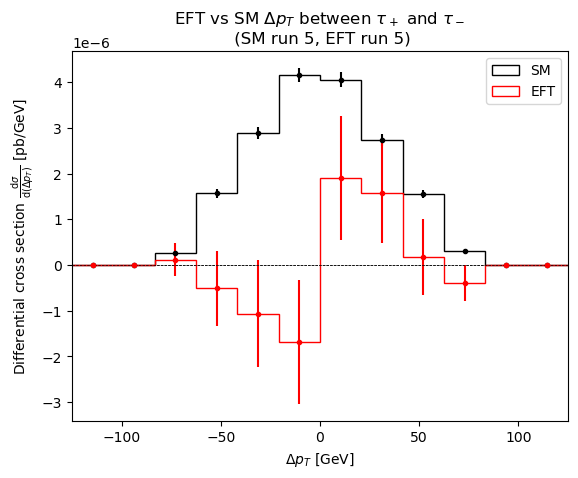

In [23]:
"""Plot the delta pt between the two taus ordered by charge
set sm and eft to the index of the sample run"""

sm = 5
eft = 5
bins = 12
plot_range = (-125, 125)

delta_pt_tau_charge_sm = delta_pt_charge(sm_taus[sm-1])
delta_pt_tau_charge_eft = delta_pt_charge(eft_taus[eft-1])

histogram(delta_pt_tau_charge_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_pt_tau_charge_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$\Delta p_T$ [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta p_T)}$ [pb/GeV]')
plt.title(r'EFT vs SM $\Delta p_T$ between $\tau_+$ and $\tau_-$' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_pt_tau_charge")

q:  6.884584081292942
a =  0.22936642851593836


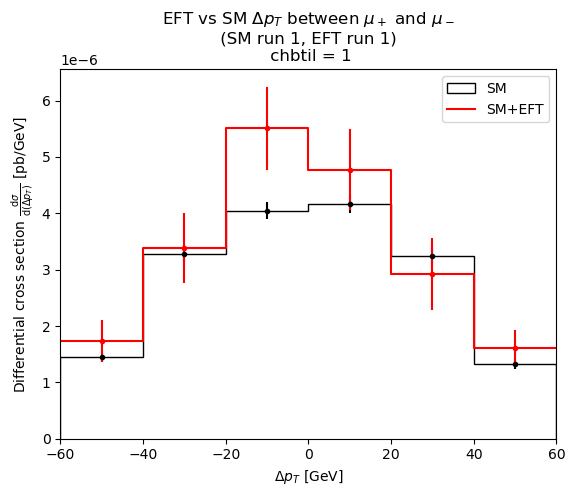

In [60]:
"""Plot the delta pt between the two muons ordered by charge
set sm and eft to the index of the sample run"""

sm = 1
eft = 1
bins = 6
plot_range = (-60, 60) # NOTE: take care with the range! Could technically be cutting some muons off

delta_pt_mu_charge_sm = delta_pt_charge(sm_muons[sm-1])
delta_pt_mu_charge_eft = delta_pt_charge(eft_muons[eft-1])

sm_histo, sm_err = histogram(delta_pt_mu_charge_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err = histogram(delta_pt_mu_charge_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range, False)
smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, bins, 'SM+EFT', 'r', plot_range)

# H1 = likelihood(smeft_histo, smeft_histo)
# H0 = likelihood(smeft_histo, sm_histo[0])
# H0 = likelihood(smeft_histo, sm_histo[0])
# H1 = likelihood(sm_histo[0], sm_histo[0])
# print('H1 Likelihood: ', H1,'\nH0 Likelihood: ', H0)
# print('q: ', np_q(H0,H1))
# print('a = ', find_p_val(np_q(H0,H1), bins-1))
q = likelihood_bz(sm_histo[0], sm_err, smeft_histo, smeft_err, eft_err)
print('q: ', q)
print('a = ', find_p_val(q, bins-1))

plt.xlabel(r'$\Delta p_T$ [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta p_T)}$ [pb/GeV]')
plt.title(r'EFT vs SM $\Delta p_T$ between $\mu_+$ and $\mu_-$' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 1')
plt.savefig("delta_pt_mu_charge")

In [45]:
"""The 'genuine' CP odd observable from https://arxiv.org/abs/0911.2933"""
def calc_Phi(a, b, cross, subtraction):
    # NOTE: this takes a while to run... is there a more efficient method?
    """This is pretty long, so let's use a function instead of writing it twice
    so for the (l+ x l-) dot z, let's do it separately - this is mayber neater anyway
    I'm very much hoping I can subtract the 4 vectors and it will act like 3-momentum
    I should check this"""
    unit_z = vector.obj(x=0, y=0, z=1)
    # start = time.time()
    # a_unit = a / a.mag
    # b_unit = b / b.mag
    # crossp = a_unit.cross(b_unit)
    # 'As I said, weirdly returns an awkward array, so I have to convert it to a vector'
    # crossp_vec = vector.obj(x=crossp.x, y=crossp.y, z=crossp.z)
    ang = math.asin((cross.dot(unit_z)))
    # sign = np.sign((a-b).dot(unit_z))
    sign = np.sign(subtraction.dot(unit_z))
    return sign*ang

def cp_Phi(leptons):
    cp_Phi = []
    crosses = cross_leptons(leptons)
    subtraction = leptons[:,0] - leptons[:,1]
    for i, lep in enumerate(leptons):
        unit_z = vector.obj(x=0, y=0, z=1)
        if lep[0].charge == 1:
            cp_Phi.append(calc_Phi(lep[0], lep[1], crosses[i], subtraction[i]))
        else:
            cp_Phi.append(calc_Phi(lep[1], lep[0], -crosses[i], -subtraction[i]))
    return cp_Phi

def cross_leptons(leptons):
    '''In the above we need the cross product of the momentum between vectors
    this is much quicker to calculate in one go and use vector.zip
    and flip the sign of where required
    This is because for some bizarre reason, .cross returns an awkward array, not a vector
    so we need to calculate and reform (zip) a vector object'''
    crosses = (leptons[:,0]/leptons[:,0].mag).cross(leptons[:,1]/leptons[:,1].mag)
    # not forgetting that the cross product needs the unit vector, so divide by mag
    crosses_vec = vector.zip({'x':ak.to_numpy(crosses.x), 'y':ak.to_numpy(crosses.y), 'z':ak.to_numpy(crosses.z)})
    '''In the end, this alone didn't make it much quicker
    it seems nicer, so I'll leave it, but may be worth returning to see if it is still right
    what made it much faster is doing a similar thing for the subtraction, so it's probably worth doing both like this'''
    return crosses_vec

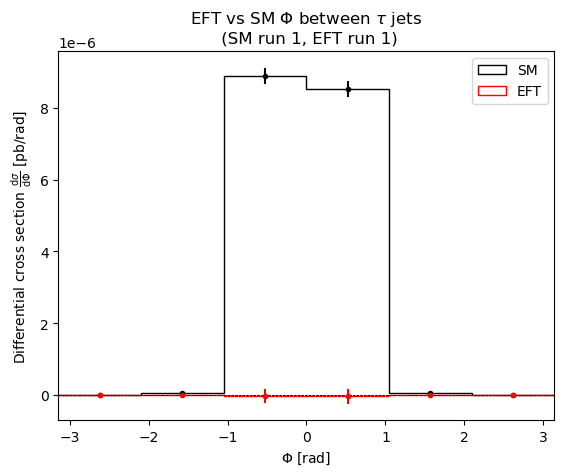

In [60]:
"""Plot the observable Phi between the two taus ordered by charge
set sm and eft to the index of the sample run"""

sm = 1
eft = 1
bins = 6
plot_range = (-math.pi, math.pi) # NOTE: take care with the range! Could technically be cutting some muons off

cp_Phi_tau_sm = cp_Phi(sm_taus[sm-1])
cp_Phi_tau_eft = cp_Phi(eft_taus[eft-1])

histogram(cp_Phi_tau_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(cp_Phi_tau_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$\Phi$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}\Phi}$ [pb/rad]')
plt.title(r'EFT vs SM $\Phi$ between $\tau$ jets' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("cp_Phi_tau")

q:  6.371943543436357
a =  0.2716903321899654


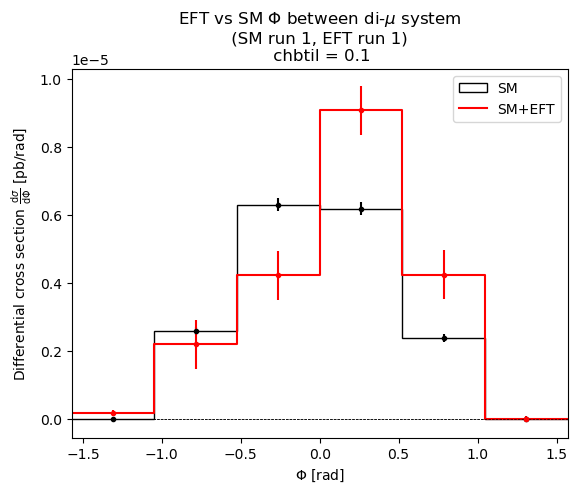

In [61]:
"""Plot the observable Phi between the two muons ordered by charge
set sm and eft to the index of the sample run"""

sm = 1
eft = 1
# bins = 12
# plot_range = (-math.pi, math.pi) # NOTE: take care with the range! Could technically be cutting some muons off
bins = 6
plot_range = (-math.pi/2, math.pi/2)

cp_Phi_mu_sm = cp_Phi(sm_muons[sm-1])
cp_Phi_mu_eft = cp_Phi(eft_muons[eft-1])

sm_histo, sm_err = histogram(cp_Phi_mu_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err = histogram(cp_Phi_mu_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range, False)
smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, bins, 'SM+EFT', 'r', plot_range)

q = likelihood_bz(sm_histo[0], sm_err, smeft_histo, smeft_err, eft_err)
print('q: ', q)
print('a = ', find_p_val(q, bins-1))

plt.xlabel(r'$\Phi$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}\Phi}$ [pb/rad]')
plt.title(r'EFT vs SM $\Phi$ between di-$\mu$ system' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 0.1')
plt.savefig("cp_Phi_mu")